In [39]:
import os 
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from dotenv import load_dotenv
import cv2 
import supervision as sv
import torch 


In [27]:
!nvidia-smi # check GPU availability 


In [28]:
# Declare paths
HOME = os.getcwd()
LOCATION = f'{HOME}/vehicles'
CHECKPOINT_DIR = f'{HOME}/checkpoints'

print(LOCATION)

In [40]:
# Declare constraints 
MODEL_ARCH = 'yolo_nas_s' # model architecture load from .env (yolo nas s)
EXPERIMENT_NAME = 'vehicles' # name of experiment (data folder)
CLASSES = ['0'] # Array of class label names. Found in YAML file. 
BATCH_SIZE = 8 # # of batches
MAX_EPOCHS = 25 # # of epochs
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"


In [30]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [31]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [32]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'show_all_warnings': True,
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Thu Jun 20 12:51:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0  On |                  N/A |
|  0%   53C    P8    24W / 320W |    336MiB / 10240MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/home/lpalombi/Desktop/YOLONAS_Training/vehicles


[2024-06-20 12:51:41] WARNING - yolo_format_detection.py - 9 images are note associated to any label file
[2024-06-20 12:51:41] WARNING - yolo_format_detection.py - As a consequence, 433/442 images and 433/433 label files will be used.
[2024-06-20 12:51:41] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 433/433 [00:00<00:00, 4656.29it/s]
[2024-06-20 12:51:41] WARNING - yolo_format_detection.py - 1 images are note associated to any label file
[2024-06-20 12:51:41] WARNING - yolo_format_detection.py - As a consequence, 54/55 images and 54/54 label files will be used.
[2024-06-20 12:51:41] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 54/54 [00:00<00:00, 3270.98it/s]
[2024-06-20 12:5

In [33]:
train_data.dataset.transforms

In [34]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

Indexing dataset annotations: 100%|██████████| 53/53 [00:00<00:00, 6237.32it/s]


[2024-06-20 12:51:42] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-20 12:51:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-06-20 12:51:42] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [35]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [36]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-06-20 12:51:42] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240620_125142_450900`
[2024-06-20 12:51:42] INFO - sg_trainer.py - Checkpoints directory: /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900
[2024-06-20 12:51:42] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/console_Jun20_12_51_42.txt


[2024-06-20 12:51:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (1 available on the machine)
    - Full dataset size:            433        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         54         (len(train_loader))
    - Gradient updates per epoch:   54         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.13K parameters), WD: 0.0001, (18.98M parameters)

[2024-06-20 12:51:44] INFO - sg_trainer.py - Started training for 2

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.1626
│   ├── Ppyoloeloss/loss_iou = 0.7002
│   ├── Ppyoloeloss/loss_dfl = 0.6064
│   └── Ppyoloeloss/loss = 3.4693
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3062
    ├── Ppyoloeloss/loss_iou = 0.7446
    ├── Ppyoloeloss/loss_dfl = 0.5587
    ├── Ppyoloeloss/loss = 3.6094
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0075
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.03



Validating epoch 1: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]
[2024-06-20 13:00:07] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:00:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9593271017074585


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9941
│   │   ├── Epoch N-1      = 2.1626 (↘ -1.1685)
│   │   └── Best until now = 2.1626 (↘ -1.1685)
│   ├── Ppyoloeloss/loss_iou = 0.4822
│   │   ├── Epoch N-1      = 0.7002 (↘ -0.218)
│   │   └── Best until now = 0.7002 (↘ -0.218)
│   ├── Ppyoloeloss/loss_dfl = 0.4392
│   │   ├── Epoch N-1      = 0.6064 (↘ -0.1672)
│   │   └── Best until now = 0.6064 (↘ -0.1672)
│   └── Ppyoloeloss/loss = 1.9156
│       ├── Epoch N-1      = 3.4693 (↘ -1.5537)
│       └── Best until now = 3.4693 (↘ -1.5537)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7614
    │   ├── Epoch N-1      = 2.3062 (↘ -1.5447)
    │   └── Best until now = 2.3062 (↘ -1.5447)
    ├── Ppyoloeloss/loss_iou = 0.3852
    │   ├── Epoch N-1      = 0.7446 (↘ -0.3594)
    │   └── Best until now = 0.7446 (↘ -0.3594)
    ├── Ppyoloeloss/loss_dfl = 0.362
    │   ├── Epoch N-1      = 0.5587 (↘ -0.1966)
    │   └── Best until now = 0.5587 (↘ -0.1966)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]
[2024-06-20 13:04:21] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:04:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9641417860984802


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7772
│   │   ├── Epoch N-1      = 0.9941 (↘ -0.2169)
│   │   └── Best until now = 0.9941 (↘ -0.2169)
│   ├── Ppyoloeloss/loss_iou = 0.4281
│   │   ├── Epoch N-1      = 0.4822 (↘ -0.0542)
│   │   └── Best until now = 0.4822 (↘ -0.0542)
│   ├── Ppyoloeloss/loss_dfl = 0.4145
│   │   ├── Epoch N-1      = 0.4392 (↘ -0.0247)
│   │   └── Best until now = 0.4392 (↘ -0.0247)
│   └── Ppyoloeloss/loss = 1.6198
│       ├── Epoch N-1      = 1.9156 (↘ -0.2958)
│       └── Best until now = 1.9156 (↘ -0.2958)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6549
    │   ├── Epoch N-1      = 0.7614 (↘ -0.1065)
    │   └── Best until now = 0.7614 (↘ -0.1065)
    ├── Ppyoloeloss/loss_iou = 0.3403
    │   ├── Epoch N-1      = 0.3852 (↘ -0.045)
    │   └── Best until now = 0.3852 (↘ -0.045)
    ├── Ppyoloeloss/loss_dfl = 0.3458
    │   ├── Epoch N-1      = 0.362  (↘ -0.0162)
    │   └── Best until now = 0.362  (↘ -0.0162)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7591
│   │   ├── Epoch N-1      = 0.7772 (↘ -0.0181)
│   │   └── Best until now = 0.7772 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.4091
│   │   ├── Epoch N-1      = 0.4281 (↘ -0.019)
│   │   └── Best until now = 0.4281 (↘ -0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.4191
│   │   ├── Epoch N-1      = 0.4145 (↗ 0.0046)
│   │   └── Best until now = 0.4145 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.5873
│       ├── Epoch N-1      = 1.6198 (↘ -0.0325)
│       └── Best until now = 1.6198 (↘ -0.0325)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8667
    │   ├── Epoch N-1      = 0.6549 (↗ 0.2118)
    │   └── Best until now = 0.6549 (↗ 0.2118)
    ├── Ppyoloeloss/loss_iou = 0.3727
    │   ├── Epoch N-1      = 0.3403 (↗ 0.0324)
    │   └── Best until now = 0.3403 (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.3721
    │   ├── Epoch N-1      = 0.3458 (↗ 0.0263)
    │   └── Best until now = 0.3458 (↗ 0.0263)
    ├── Ppyoloeloss/loss = 1.611

Validating epoch 4: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
[2024-06-20 13:12:04] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:12:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9890555143356323


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7203
│   │   ├── Epoch N-1      = 0.7591 (↘ -0.0388)
│   │   └── Best until now = 0.7591 (↘ -0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.4071
│   │   ├── Epoch N-1      = 0.4091 (↘ -0.002)
│   │   └── Best until now = 0.4091 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4034
│   │   ├── Epoch N-1      = 0.4191 (↘ -0.0156)
│   │   └── Best until now = 0.4145 (↘ -0.0111)
│   └── Ppyoloeloss/loss = 1.5308
│       ├── Epoch N-1      = 1.5873 (↘ -0.0564)
│       └── Best until now = 1.5873 (↘ -0.0564)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6254
    │   ├── Epoch N-1      = 0.8667 (↘ -0.2413)
    │   └── Best until now = 0.6549 (↘ -0.0295)
    ├── Ppyoloeloss/loss_iou = 0.3419
    │   ├── Epoch N-1      = 0.3727 (↘ -0.0308)
    │   └── Best until now = 0.3403 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.3407
    │   ├── Epoch N-1      = 0.3721 (↘ -0.0314)
    │   └── Best until now = 0.3458 (↘ -0.0051)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]
[2024-06-20 13:15:45] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:15:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9980030655860901


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.688
│   │   ├── Epoch N-1      = 0.7203 (↘ -0.0324)
│   │   └── Best until now = 0.7203 (↘ -0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.3878
│   │   ├── Epoch N-1      = 0.4071 (↘ -0.0193)
│   │   └── Best until now = 0.4071 (↘ -0.0193)
│   ├── Ppyoloeloss/loss_dfl = 0.3959
│   │   ├── Epoch N-1      = 0.4034 (↘ -0.0076)
│   │   └── Best until now = 0.4034 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 1.4716
│       ├── Epoch N-1      = 1.5308 (↘ -0.0592)
│       └── Best until now = 1.5308 (↘ -0.0592)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.589
    │   ├── Epoch N-1      = 0.6254 (↘ -0.0364)
    │   └── Best until now = 0.6254 (↘ -0.0364)
    ├── Ppyoloeloss/loss_iou = 0.3393
    │   ├── Epoch N-1      = 0.3419 (↘ -0.0027)
    │   └── Best until now = 0.3403 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.3453
    │   ├── Epoch N-1      = 0.3407 (↗ 0.0046)
    │   └── Best until now = 0.3407 (↗ 0.0046)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]
[2024-06-20 13:19:26] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:19:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9992057085037231


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6678
│   │   ├── Epoch N-1      = 0.688  (↘ -0.0201)
│   │   └── Best until now = 0.688  (↘ -0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.3757
│   │   ├── Epoch N-1      = 0.3878 (↘ -0.0121)
│   │   └── Best until now = 0.3878 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.3881
│   │   ├── Epoch N-1      = 0.3959 (↘ -0.0078)
│   │   └── Best until now = 0.3959 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.4317
│       ├── Epoch N-1      = 1.4716 (↘ -0.04)
│       └── Best until now = 1.4716 (↘ -0.04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5777
    │   ├── Epoch N-1      = 0.589  (↘ -0.0113)
    │   └── Best until now = 0.589  (↘ -0.0113)
    ├── Ppyoloeloss/loss_iou = 0.2869
    │   ├── Epoch N-1      = 0.3393 (↘ -0.0524)
    │   └── Best until now = 0.3393 (↘ -0.0524)
    ├── Ppyoloeloss/loss_dfl = 0.3158
    │   ├── Epoch N-1      = 0.3453 (↘ -0.0294)
    │   └── Best until now = 0.3407 (↘ -0.0249)
    ├── Ppyoloeloss/loss =

Validating epoch 7: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]
[2024-06-20 13:23:09] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:23:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9998390078544617


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6626
│   │   ├── Epoch N-1      = 0.6678 (↘ -0.0052)
│   │   └── Best until now = 0.6678 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.364
│   │   ├── Epoch N-1      = 0.3757 (↘ -0.0118)
│   │   └── Best until now = 0.3757 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_dfl = 0.379
│   │   ├── Epoch N-1      = 0.3881 (↘ -0.0091)
│   │   └── Best until now = 0.3881 (↘ -0.0091)
│   └── Ppyoloeloss/loss = 1.4056
│       ├── Epoch N-1      = 1.4317 (↘ -0.0261)
│       └── Best until now = 1.4317 (↘ -0.0261)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5685
    │   ├── Epoch N-1      = 0.5777 (↘ -0.0093)
    │   └── Best until now = 0.5777 (↘ -0.0093)
    ├── Ppyoloeloss/loss_iou = 0.2903
    │   ├── Epoch N-1      = 0.2869 (↗ 0.0034)
    │   └── Best until now = 0.2869 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.3203
    │   ├── Epoch N-1      = 0.3158 (↗ 0.0045)
    │   └── Best until now = 0.3158 (↗ 0.0045)
    ├── Ppyoloeloss/loss = 1

Validating epoch 8: 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.645
│   │   ├── Epoch N-1      = 0.6626 (↘ -0.0176)
│   │   └── Best until now = 0.6626 (↘ -0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.354
│   │   ├── Epoch N-1      = 0.364  (↘ -0.01)
│   │   └── Best until now = 0.364  (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.3756
│   │   ├── Epoch N-1      = 0.379  (↘ -0.0034)
│   │   └── Best until now = 0.379  (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.3746
│       ├── Epoch N-1      = 1.4056 (↘ -0.031)
│       └── Best until now = 1.4056 (↘ -0.031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5626
    │   ├── Epoch N-1      = 0.5685 (↘ -0.0058)
    │   └── Best until now = 0.5685 (↘ -0.0058)
    ├── Ppyoloeloss/loss_iou = 0.2784
    │   ├── Epoch N-1      = 0.2903 (↘ -0.0119)
    │   └── Best until now = 0.2869 (↘ -0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.3125
    │   ├── Epoch N-1      = 0.3203 (↘ -0.0079)
    │   └── Best until now = 0.3158 (↘ -0.0034)
    ├── Ppyoloeloss/loss = 1.1

Validating epoch 9: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6345
│   │   ├── Epoch N-1      = 0.645  (↘ -0.0105)
│   │   └── Best until now = 0.645  (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.3463
│   │   ├── Epoch N-1      = 0.354  (↘ -0.0077)
│   │   └── Best until now = 0.354  (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.371
│   │   ├── Epoch N-1      = 0.3756 (↘ -0.0045)
│   │   └── Best until now = 0.3756 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.3518
│       ├── Epoch N-1      = 1.3746 (↘ -0.0228)
│       └── Best until now = 1.3746 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5652
    │   ├── Epoch N-1      = 0.5626 (↗ 0.0026)
    │   └── Best until now = 0.5626 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.2704
    │   ├── Epoch N-1      = 0.2784 (↘ -0.008)
    │   └── Best until now = 0.2784 (↘ -0.008)
    ├── Ppyoloeloss/loss_dfl = 0.3085
    │   ├── Epoch N-1      = 0.3125 (↘ -0.004)
    │   └── Best until now = 0.3125 (↘ -0.004)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 10: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
[2024-06-20 13:34:19] INFO - base_sg_logger.py - Checkpoint saved in /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth
[2024-06-20 13:34:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 1.0


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6222
│   │   ├── Epoch N-1      = 0.6345 (↘ -0.0124)
│   │   └── Best until now = 0.6345 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.338
│   │   ├── Epoch N-1      = 0.3463 (↘ -0.0083)
│   │   └── Best until now = 0.3463 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.3649
│   │   ├── Epoch N-1      = 0.371  (↘ -0.0062)
│   │   └── Best until now = 0.371  (↘ -0.0062)
│   └── Ppyoloeloss/loss = 1.325
│       ├── Epoch N-1      = 1.3518 (↘ -0.0268)
│       └── Best until now = 1.3518 (↘ -0.0268)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5745
    │   ├── Epoch N-1      = 0.5652 (↗ 0.0092)
    │   └── Best until now = 0.5626 (↗ 0.0118)
    ├── Ppyoloeloss/loss_iou = 0.3013
    │   ├── Epoch N-1      = 0.2704 (↗ 0.0309)
    │   └── Best until now = 0.2704 (↗ 0.0309)
    ├── Ppyoloeloss/loss_dfl = 0.3232
    │   ├── Epoch N-1      = 0.3085 (↗ 0.0147)
    │   └── Best until now = 0.3085 (↗ 0.0147)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 11: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6055
│   │   ├── Epoch N-1      = 0.6222 (↘ -0.0167)
│   │   └── Best until now = 0.6222 (↘ -0.0167)
│   ├── Ppyoloeloss/loss_iou = 0.3316
│   │   ├── Epoch N-1      = 0.338  (↘ -0.0064)
│   │   └── Best until now = 0.338  (↘ -0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.3545
│   │   ├── Epoch N-1      = 0.3649 (↘ -0.0103)
│   │   └── Best until now = 0.3649 (↘ -0.0103)
│   └── Ppyoloeloss/loss = 1.2916
│       ├── Epoch N-1      = 1.325  (↘ -0.0334)
│       └── Best until now = 1.325  (↘ -0.0334)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5384
    │   ├── Epoch N-1      = 0.5745 (↘ -0.0361)
    │   └── Best until now = 0.5626 (↘ -0.0242)
    ├── Ppyoloeloss/loss_iou = 0.2619
    │   ├── Epoch N-1      = 0.3013 (↘ -0.0394)
    │   └── Best until now = 0.2704 (↘ -0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.2994
    │   ├── Epoch N-1      = 0.3232 (↘ -0.0238)
    │   └── Best until now = 0.3085 (↘ -0.0091)
    ├── Ppyoloeloss/l

Validating epoch 12: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5974
│   │   ├── Epoch N-1      = 0.6055 (↘ -0.0081)
│   │   └── Best until now = 0.6055 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_iou = 0.3254
│   │   ├── Epoch N-1      = 0.3316 (↘ -0.0061)
│   │   └── Best until now = 0.3316 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.3547
│   │   ├── Epoch N-1      = 0.3545 (↗ 0.0002)
│   │   └── Best until now = 0.3545 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.2775
│       ├── Epoch N-1      = 1.2916 (↘ -0.0141)
│       └── Best until now = 1.2916 (↘ -0.0141)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5465
    │   ├── Epoch N-1      = 0.5384 (↗ 0.0081)
    │   └── Best until now = 0.5384 (↗ 0.0081)
    ├── Ppyoloeloss/loss_iou = 0.2651
    │   ├── Epoch N-1      = 0.2619 (↗ 0.0032)
    │   └── Best until now = 0.2619 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.3037
    │   ├── Epoch N-1      = 0.2994 (↗ 0.0043)
    │   └── Best until now = 0.2994 (↗ 0.0043)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 13: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5848
│   │   ├── Epoch N-1      = 0.5974 (↘ -0.0126)
│   │   └── Best until now = 0.5974 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_iou = 0.3149
│   │   ├── Epoch N-1      = 0.3254 (↘ -0.0105)
│   │   └── Best until now = 0.3254 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.3512
│   │   ├── Epoch N-1      = 0.3547 (↘ -0.0035)
│   │   └── Best until now = 0.3545 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.2509
│       ├── Epoch N-1      = 1.2775 (↘ -0.0266)
│       └── Best until now = 1.2775 (↘ -0.0266)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5437
    │   ├── Epoch N-1      = 0.5465 (↘ -0.0028)
    │   └── Best until now = 0.5384 (↗ 0.0053)
    ├── Ppyoloeloss/loss_iou = 0.248
    │   ├── Epoch N-1      = 0.2651 (↘ -0.0171)
    │   └── Best until now = 0.2619 (↘ -0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.2951
    │   ├── Epoch N-1      = 0.3037 (↘ -0.0086)
    │   └── Best until now = 0.2994 (↘ -0.0043)
    ├── Ppyoloeloss/los

Validating epoch 14: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5838
│   │   ├── Epoch N-1      = 0.5848 (↘ -0.001)
│   │   └── Best until now = 0.5848 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.3082
│   │   ├── Epoch N-1      = 0.3149 (↘ -0.0067)
│   │   └── Best until now = 0.3149 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.3427
│   │   ├── Epoch N-1      = 0.3512 (↘ -0.0085)
│   │   └── Best until now = 0.3512 (↘ -0.0085)
│   └── Ppyoloeloss/loss = 1.2347
│       ├── Epoch N-1      = 1.2509 (↘ -0.0162)
│       └── Best until now = 1.2509 (↘ -0.0162)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5374
    │   ├── Epoch N-1      = 0.5437 (↘ -0.0063)
    │   └── Best until now = 0.5384 (↘ -0.001)
    ├── Ppyoloeloss/loss_iou = 0.2594
    │   ├── Epoch N-1      = 0.248  (↗ 0.0114)
    │   └── Best until now = 0.248  (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 0.2994
    │   ├── Epoch N-1      = 0.2951 (↗ 0.0043)
    │   └── Best until now = 0.2951 (↗ 0.0043)
    ├── Ppyoloeloss/loss = 1

Validating epoch 15: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5707
│   │   ├── Epoch N-1      = 0.5838 (↘ -0.0132)
│   │   └── Best until now = 0.5838 (↘ -0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.3036
│   │   ├── Epoch N-1      = 0.3082 (↘ -0.0046)
│   │   └── Best until now = 0.3082 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.338
│   │   ├── Epoch N-1      = 0.3427 (↘ -0.0047)
│   │   └── Best until now = 0.3427 (↘ -0.0047)
│   └── Ppyoloeloss/loss = 1.2123
│       ├── Epoch N-1      = 1.2347 (↘ -0.0224)
│       └── Best until now = 1.2347 (↘ -0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5154
    │   ├── Epoch N-1      = 0.5374 (↘ -0.022)
    │   └── Best until now = 0.5374 (↘ -0.022)
    ├── Ppyoloeloss/loss_iou = 0.2542
    │   ├── Epoch N-1      = 0.2594 (↘ -0.0052)
    │   └── Best until now = 0.248  (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.2993
    │   ├── Epoch N-1      = 0.2994 (↘ -1e-04)
    │   └── Best until now = 0.2951 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 

Validating epoch 16: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5643
│   │   ├── Epoch N-1      = 0.5707 (↘ -0.0063)
│   │   └── Best until now = 0.5707 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.2997
│   │   ├── Epoch N-1      = 0.3036 (↘ -0.0039)
│   │   └── Best until now = 0.3036 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.3395
│   │   ├── Epoch N-1      = 0.338  (↗ 0.0015)
│   │   └── Best until now = 0.338  (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.2035
│       ├── Epoch N-1      = 1.2123 (↘ -0.0087)
│       └── Best until now = 1.2123 (↘ -0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5315
    │   ├── Epoch N-1      = 0.5154 (↗ 0.0161)
    │   └── Best until now = 0.5154 (↗ 0.0161)
    ├── Ppyoloeloss/loss_iou = 0.2463
    │   ├── Epoch N-1      = 0.2542 (↘ -0.0079)
    │   └── Best until now = 0.248  (↘ -0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.2951
    │   ├── Epoch N-1      = 0.2993 (↘ -0.0042)
    │   └── Best until now = 0.2951 (↗ 0.0)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 17: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5643
│   │   ├── Epoch N-1      = 0.5643 (↘ -0.0)
│   │   └── Best until now = 0.5643 (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.2913
│   │   ├── Epoch N-1      = 0.2997 (↘ -0.0084)
│   │   └── Best until now = 0.2997 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.3373
│   │   ├── Epoch N-1      = 0.3395 (↘ -0.0021)
│   │   └── Best until now = 0.338  (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.1929
│       ├── Epoch N-1      = 1.2035 (↘ -0.0106)
│       └── Best until now = 1.2035 (↘ -0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5251
    │   ├── Epoch N-1      = 0.5315 (↘ -0.0065)
    │   └── Best until now = 0.5154 (↗ 0.0097)
    ├── Ppyoloeloss/loss_iou = 0.2451
    │   ├── Epoch N-1      = 0.2463 (↘ -0.0011)
    │   └── Best until now = 0.2463 (↘ -0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.2953
    │   ├── Epoch N-1      = 0.2951 (↗ 1e-04)
    │   └── Best until now = 0.2951 (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1.06

Validating epoch 18: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5511
│   │   ├── Epoch N-1      = 0.5643 (↘ -0.0132)
│   │   └── Best until now = 0.5643 (↘ -0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.2815
│   │   ├── Epoch N-1      = 0.2913 (↘ -0.0097)
│   │   └── Best until now = 0.2913 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.333
│   │   ├── Epoch N-1      = 0.3373 (↘ -0.0044)
│   │   └── Best until now = 0.3373 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.1656
│       ├── Epoch N-1      = 1.1929 (↘ -0.0273)
│       └── Best until now = 1.1929 (↘ -0.0273)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5134
    │   ├── Epoch N-1      = 0.5251 (↘ -0.0117)
    │   └── Best until now = 0.5154 (↘ -0.002)
    ├── Ppyoloeloss/loss_iou = 0.2399
    │   ├── Epoch N-1      = 0.2451 (↘ -0.0053)
    │   └── Best until now = 0.2451 (↘ -0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.2939
    │   ├── Epoch N-1      = 0.2953 (↘ -0.0014)
    │   └── Best until now = 0.2951 (↘ -0.0012)
    ├── Ppyoloeloss/los

Validating epoch 19: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5526
│   │   ├── Epoch N-1      = 0.5511 (↗ 0.0016)
│   │   └── Best until now = 0.5511 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.2916
│   │   ├── Epoch N-1      = 0.2815 (↗ 0.0101)
│   │   └── Best until now = 0.2815 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.3358
│   │   ├── Epoch N-1      = 0.333  (↗ 0.0028)
│   │   └── Best until now = 0.333  (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.1801
│       ├── Epoch N-1      = 1.1656 (↗ 0.0145)
│       └── Best until now = 1.1656 (↗ 0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5108
    │   ├── Epoch N-1      = 0.5134 (↘ -0.0026)
    │   └── Best until now = 0.5134 (↘ -0.0026)
    ├── Ppyoloeloss/loss_iou = 0.2511
    │   ├── Epoch N-1      = 0.2399 (↗ 0.0112)
    │   └── Best until now = 0.2399 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 0.298
    │   ├── Epoch N-1      = 0.2939 (↗ 0.0041)
    │   └── Best until now = 0.2939 (↗ 0.0041)
    ├── Ppyoloeloss/loss = 1.0598


Validating epoch 20: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5438
│   │   ├── Epoch N-1      = 0.5526 (↘ -0.0089)
│   │   └── Best until now = 0.5511 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.281
│   │   ├── Epoch N-1      = 0.2916 (↘ -0.0106)
│   │   └── Best until now = 0.2815 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3287
│   │   ├── Epoch N-1      = 0.3358 (↘ -0.0072)
│   │   └── Best until now = 0.333  (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.1534
│       ├── Epoch N-1      = 1.1801 (↘ -0.0267)
│       └── Best until now = 1.1656 (↘ -0.0121)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5042
    │   ├── Epoch N-1      = 0.5108 (↘ -0.0065)
    │   └── Best until now = 0.5108 (↘ -0.0065)
    ├── Ppyoloeloss/loss_iou = 0.2457
    │   ├── Epoch N-1      = 0.2511 (↘ -0.0054)
    │   └── Best until now = 0.2399 (↗ 0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.2922
    │   ├── Epoch N-1      = 0.298  (↘ -0.0058)
    │   └── Best until now = 0.2939 (↘ -0.0017)
    ├── Ppyoloeloss/los

Validating epoch 21: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5447
│   │   ├── Epoch N-1      = 0.5438 (↗ 0.0009)
│   │   └── Best until now = 0.5438 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.2812
│   │   ├── Epoch N-1      = 0.281  (↗ 0.0002)
│   │   └── Best until now = 0.281  (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3308
│   │   ├── Epoch N-1      = 0.3287 (↗ 0.0021)
│   │   └── Best until now = 0.3287 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.1566
│       ├── Epoch N-1      = 1.1534 (↗ 0.0032)
│       └── Best until now = 1.1534 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.503
    │   ├── Epoch N-1      = 0.5042 (↘ -0.0012)
    │   └── Best until now = 0.5042 (↘ -0.0012)
    ├── Ppyoloeloss/loss_iou = 0.2436
    │   ├── Epoch N-1      = 0.2457 (↘ -0.0021)
    │   └── Best until now = 0.2399 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 0.2943
    │   ├── Epoch N-1      = 0.2922 (↗ 0.0021)
    │   └── Best until now = 0.2922 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.0409

Validating epoch 22: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5358
│   │   ├── Epoch N-1      = 0.5447 (↘ -0.0089)
│   │   └── Best until now = 0.5438 (↘ -0.008)
│   ├── Ppyoloeloss/loss_iou = 0.2719
│   │   ├── Epoch N-1      = 0.2812 (↘ -0.0093)
│   │   └── Best until now = 0.281  (↘ -0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.3257
│   │   ├── Epoch N-1      = 0.3308 (↘ -0.0051)
│   │   └── Best until now = 0.3287 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.1334
│       ├── Epoch N-1      = 1.1566 (↘ -0.0233)
│       └── Best until now = 1.1534 (↘ -0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5026
    │   ├── Epoch N-1      = 0.503  (↘ -0.0004)
    │   └── Best until now = 0.503  (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.2473
    │   ├── Epoch N-1      = 0.2436 (↗ 0.0037)
    │   └── Best until now = 0.2399 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.2951
    │   ├── Epoch N-1      = 0.2943 (↗ 0.0008)
    │   └── Best until now = 0.2922 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 

Validating epoch 23: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5343
│   │   ├── Epoch N-1      = 0.5358 (↘ -0.0015)
│   │   └── Best until now = 0.5358 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.2661
│   │   ├── Epoch N-1      = 0.2719 (↘ -0.0058)
│   │   └── Best until now = 0.2719 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.3208
│   │   ├── Epoch N-1      = 0.3257 (↘ -0.0048)
│   │   └── Best until now = 0.3257 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.1212
│       ├── Epoch N-1      = 1.1334 (↘ -0.0122)
│       └── Best until now = 1.1334 (↘ -0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5125
    │   ├── Epoch N-1      = 0.5026 (↗ 0.0098)
    │   └── Best until now = 0.5026 (↗ 0.0098)
    ├── Ppyoloeloss/loss_iou = 0.2479
    │   ├── Epoch N-1      = 0.2473 (↗ 0.0006)
    │   └── Best until now = 0.2399 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.296
    │   ├── Epoch N-1      = 0.2951 (↗ 0.0009)
    │   └── Best until now = 0.2922 (↗ 0.0038)
    ├── Ppyoloeloss/loss = 1

Validating epoch 24: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5281
│   │   ├── Epoch N-1      = 0.5343 (↘ -0.0062)
│   │   └── Best until now = 0.5343 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.2664
│   │   ├── Epoch N-1      = 0.2661 (↗ 0.0003)
│   │   └── Best until now = 0.2661 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.322
│   │   ├── Epoch N-1      = 0.3208 (↗ 0.0012)
│   │   └── Best until now = 0.3208 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.1165
│       ├── Epoch N-1      = 1.1212 (↘ -0.0047)
│       └── Best until now = 1.1212 (↘ -0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.509
    │   ├── Epoch N-1      = 0.5125 (↘ -0.0035)
    │   └── Best until now = 0.5026 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.2294
    │   ├── Epoch N-1      = 0.2479 (↘ -0.0185)
    │   └── Best until now = 0.2399 (↘ -0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.2884
    │   ├── Epoch N-1      = 0.296  (↘ -0.0076)
    │   └── Best until now = 0.2922 (↘ -0.0038)
    ├── Ppyoloeloss/loss = 1

[2024-06-20 14:28:27] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


[2024-06-20 14:28:37] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [37]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

In [38]:
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/ (stored 0%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ (stored 0%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/logs_Jun20_12_51_42.txt (deflated 79%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/events.out.tfevents.1718902302.SinelecDell.129187.0 (deflated 79%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth (deflated 8%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/events.out.tfevents.1718908118.SinelecDell.129187.1 (deflated 43%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/average_model.pth (deflated 8%)
  adding: home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142

 (deflated 8%)


In [43]:
SAVE_FOLDER = "RUN_20240620_125142_450900"

checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/{SAVE_FOLDER}/ckpt_best.pth"
print(checkpoint_path)

best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/{SAVE_FOLDER}/ckpt_best.pth"
).to(DEVICE)

/home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth


[2024-06-20 14:33:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth EMA checkpoint.


In [58]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

""""
    Analysis: 
{'PPYoloELoss/loss_cls': 0.61581695,
 'PPYoloELoss/loss_iou': 0.3107958,
 'PPYoloELoss/loss_dfl': 0.32488734,
 'PPYoloELoss/loss': 1.2515001,
 'Precision@0.50': 0.17845658957958221,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9908557534217834,
 'F1@0.50': 0.3028649389743805,
 'Best_score_threshold': 0.6700000166893005}


 
'PPYoloELoss/loss_cls': 0.61581695: High classification loss, model struggles to differentiate 
between objects/backgrounds or diff object classes 

'PPYoloELoss/loss_iou': 0.3107958: Moderate, boxes aren't perfect but its an improvement

'PPYoloELoss/loss_dfl': 0.32488734: Overall loss shows improvement to prev. set 


'Precision@0.50': 0.17845658957958221: Very high number of false positives. Detects many objects 
that are not present. 

 'Recall@0.50': 1.0: Very unlikely recall. Model is overfitting. Indicates dataset thats too small. 

 ... etc. 

 To improve: Need a better precision/recall balance. 

 - Data augmentation like random cropping, flipping, color jittering, etc. Artificially 
 increase size/diversity of training data. 
- Regularization techniques like L1/L2 weight decay or dropout layers **** helps model perform well on unseen data. 
- Hyperparameter tuning: learning rate, batch size, optimizer settings, etc..


"""

Testing:  86%|████████▌ | 6/7 [00:07<00:01,  1.23s/it]

'"\n    Analysis: \n{\'PPYoloELoss/loss_cls\': 0.61581695,\n \'PPYoloELoss/loss_iou\': 0.3107958,\n \'PPYoloELoss/loss_dfl\': 0.32488734,\n \'PPYoloELoss/loss\': 1.2515001,\n \'Precision@0.50\': 0.17845658957958221,\n \'Recall@0.50\': 1.0,\n \'mAP@0.50\': 0.9908557534217834,\n \'F1@0.50\': 0.3028649389743805,\n \'Best_score_threshold\': 0.6700000166893005}\n\n\n \n\'PPYoloELoss/loss_cls\': 0.61581695: High classification loss, model struggles to differentiate \nbetween objects/backgrounds or diff object classes \n\n\'PPYoloELoss/loss_iou\': 0.3107958: Moderate, boxes aren\'t perfect but its an improvement\n\n\'PPYoloELoss/loss_dfl\': 0.32488734: Overall loss shows improvement to prev. set \n\n\n\'Precision@0.50\': 0.17845658957958221: Very high number of false positives. Detects many objects \nthat are not present. \n\n \'Recall@0.50\': 1.0: Very unlikely recall. Model is overfitting. Indicates dataset thats too small. \n\n ... etc. \n\n To improve: Need a better precision/recall balan

Testing: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


In [46]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{LOCATION}/test/images",
    annotations_directory_path=f"{LOCATION}/test/labels",
    data_yaml_path=f"{LOCATION}/data.yaml",
    force_masks=False
)

In [48]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2024-06-20 14:36:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 14:36:25] INFO -

[2024-06-20 14:36:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [49]:
import random
random.seed(10)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `B

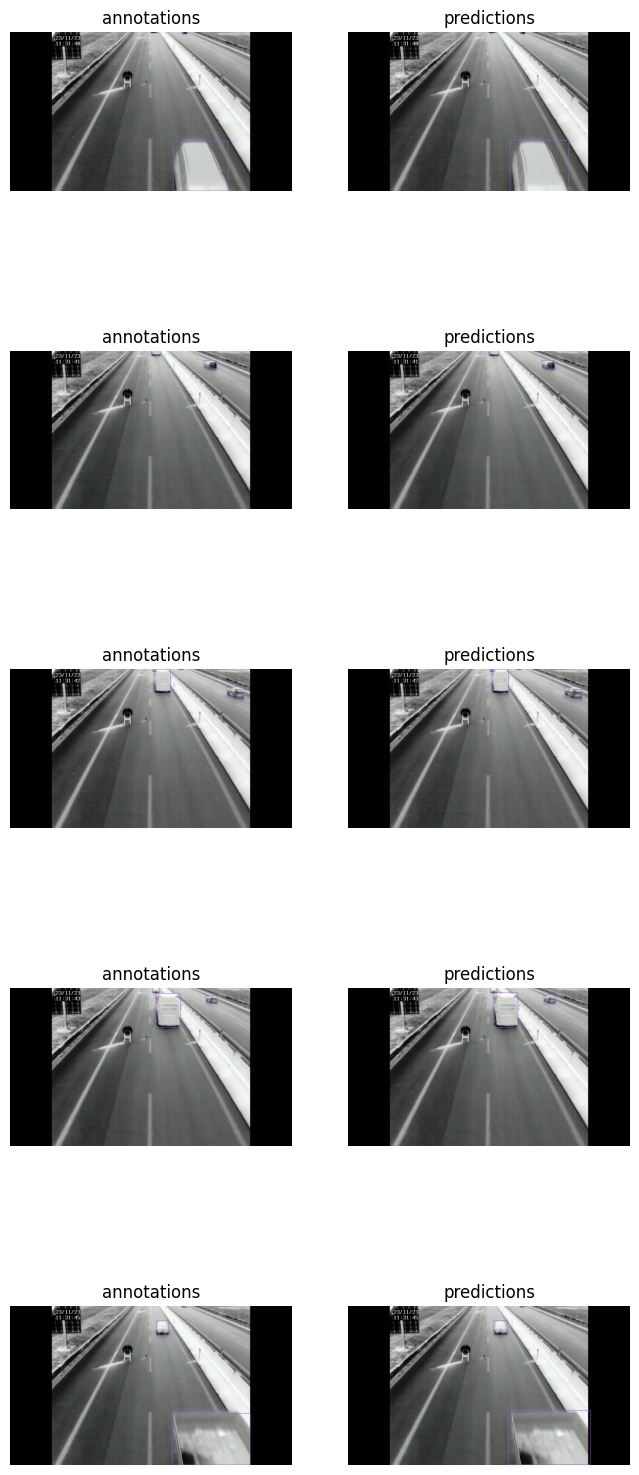

In [54]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

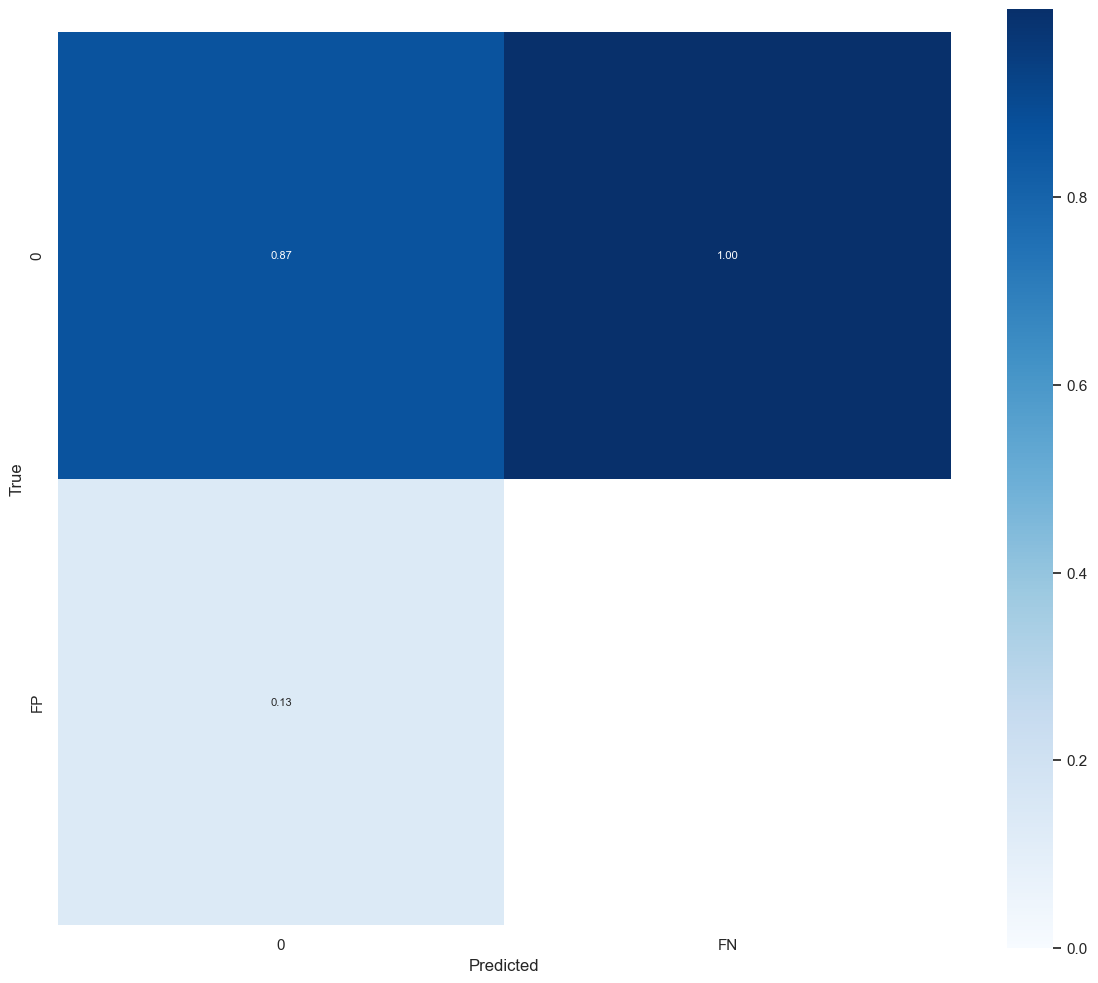

In [56]:

import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)
     